In [29]:
# LIBS
import feature_extractors
import pydub
import numpy as np
import torch
from matplotlib import pyplot as plt

In [40]:
# FOURIER PARAMS
WIN_LEN = 10  # ms
HOP_LEN = 30  # ms
SR = 16  # khz

In [41]:
# CHOOSE THIS
fe = feature_extractors.MelSpec_FE(sample_rate=SR * 1000,
                                   win_length=WIN_LEN * SR,
                                   n_fft=WIN_LEN * SR,
                                   hop_length=HOP_LEN * SR,
                                   n_mels=40)

In [66]:
# OR THIS
fe = feature_extractors.MFCC_FE(sample_rate=SR * 1000,
                                win_length=WIN_LEN * SR,
                                n_fft=WIN_LEN * SR,
                                hop_length=HOP_LEN * SR,
                                n_mels=40)

In [75]:
# SPECIFY PATH TO AUDIO
audio_path = "data/audios/_5bo0C_CrQ4.wav"
# audio_path = "record.wav"

In [50]:
#  https://stackoverflow.com/a/66922265
def pydub_to_pt(audio: pydub.AudioSegment):
    """
    Converts pydub audio segment into np.float32 of shape [duration_in_seconds*sample_rate, channels],
    where each value is in range [-1.0, 1.0]. 
    Returns tuple (audio_np_array, sample_rate).
    """
    return torch.tensor(np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels)) / (
            1 << (8 * audio.sample_width - 1))).permute(-1, -2), audio.frame_rate

In [76]:
# LOADING AUDIO
audio = pydub.AudioSegment.from_wav(audio_path)
audio = audio.set_channels(1)

In [ ]:
# SPECIFY WINDOW (FROM - TO)
WINDOW_START = 0
WINDOW_END = 2000

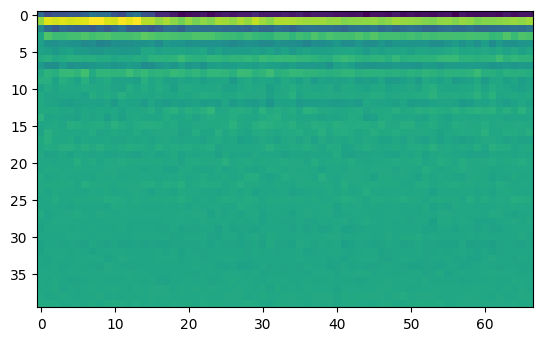

In [77]:
# SHOW FEATURES
audio_pt, _ = pydub_to_pt(audio[WINDOW_START : WINDOW_END])
features = fe(audio_pt)
plt.imshow(features.squeeze(0))